In [103]:
from bessel import bessel_roots, J_lx
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import numba as nb

## First step   
Compute the roots of the spherical bessel-functions $j_l(x)$, l $\in$ [0,...,100] and x $\in$ [0,...,100]

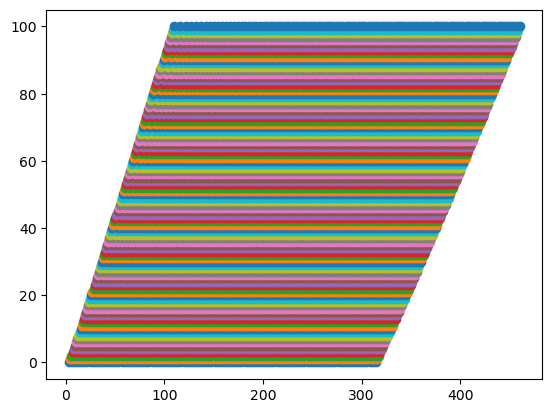

In [104]:
n_roots = 100 # index i 
l_max = 100
roots_li = bessel_roots(l_max, n_roots,scipy = True)
for l in range(len(roots_li)):
    plt.plot(roots_li[l],l*np.ones(len(roots_li[l])),'o')

In [105]:
# R = 10 fm
R  = 10 #* 1e-15
#now we want to calculate the wavenumbers. we know the relation between the wavenumber and the roots of the besse function
# j_l(k_il R) = 0.
k_il = roots_li.T / R

In [106]:
#now we want to check the orthogonality of the spherical bessel functions
#we want to calculate the integral of j_l(k_il R) * j_l(k_il R) * r^2 dr from 0 to R
#for this we use the trapezoidal rule
#@nb.njit
def trapz(func: callable, a, b, N: int ):
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    return (0.5 * func(a) + np.sum(func(r_i)) + 0.5 * func(b)) * dr
#@nb.njit
def trapz2(func: callable, a, b, N: int ):
    "trapzoidal rule with for loops"
    dr = (b-a)/N
    r_i = a + np.arange(0,N) * dr
    integral = 0
    for i in range(N):
        integral += func(r_i[i])
    return (0.5 * func(a) + integral + 0.5 * func(b)) * dr
    
    
#now we test it with a known function
@nb.njit
def f(x):
    return np.sin(x)
print(trapz(f,0,np.pi,200))
print(trapz2(f,0,np.pi,200))
#the known integral is 2


1.9999588764792147
1.9999588764792162


Now we want to check the orthonormality of the spherical bessel-functions. We use the following integral:
$$
\int_0^R j_l(k_{li} r) j_l(k_{lj} r) r^2 dr = \delta_{ij} \frac{1}{\alpha_{ij}^2}
$$
with $\alpha_{ij} = \frac{1}{j_{l-1}(k_{jl R})} \cdot \sqrt{2/R^3}$



In [107]:
@nb.jit(nopython=True)
def integrand(r,i,j,l):
    "define the integrand for the orthogonality of the spherical bessel functions"
    return J_lx(l,k_il[i,l] * r) * J_lx(l,k_il[j,l] * r) * r**2

#scipy implementation
def integrand2(r,i,j,l):
    "define the integrand for the orthogonality of the spherical bessel functions with scipy.special"
    return sp.spherical_jn(l,k_il[i,l] * r) * sp.spherical_jn(l,k_il[j,l] * r) * r**2

#now we want to calculate the integral for different l and j
#we want to store the results in a matrix

def create_integration_matrix(l_max,n_roots,scipy = False):
    "creates a matrix with the integrals of the spherical bessel functions defined above for every l and j"
    integral_lij = np.zeros((l_max,n_roots,n_roots))
    if not scipy:
        for l in range(l_max):
            for i in range(n_roots):
                for j in range(n_roots):
                    @np.vectorize
                    def func2(r):
                        return integrand(r,i,j,l)
                    integral_lij[l,i,j] = trapz(func2,0.1,R,1000)
        return integral_lij
    
    else:
        for l in range(l_max):
            for i in range(n_roots):
                for j in range(n_roots):
                    @np.vectorize
                    def func2(r):
                        return integrand2(r,i,j,l)
                    integral_lij[l,i,j] = trapz2(func2,0,R,1000)
        return integral_lij
    

print(create_integration_matrix(2,2,scipy = True))

[[[5.06605918e+01 1.10943833e-15]
  [1.10943833e-15 1.26651480e+01]]

 [[2.35952246e+01 6.41802353e-15]
  [6.41802353e-15 8.24001300e+00]]]


In [108]:
#now we want to calculate the alpha matrix
def calculate_alpha_matrix(n_roots,l_max, scipy = False):
    "calculates the alpha matrix for every l and j"
    alpha_ij = np.zeros((n_roots,l_max))
    for i in range(0,n_roots):
        alpha_ij[i,0] =  np.sqrt(2/R**3) * (i +1) * np.pi
    for l in range(1,l_max):
        for i in range(0,n_roots):
            if not scipy:
                alpha_ij[i,l] = 1 / J_lx(l-1,k_il[i,l] * R) * np.sqrt(2/R**3)
            else:
                alpha_ij[i,l] = 1/ sp.spherical_jn(l-1,k_il[i,l] * R) * np.sqrt(2/R**3)
    return alpha_ij
print(calculate_alpha_matrix(2,2,scipy = True)**-2)
print(calculate_alpha_matrix(2,2,scipy = False)**-2)


[[50.66059182 23.59522461]
 [12.66514796  8.240013  ]]
[[50.66059182 23.59522461]
 [12.66514796  8.240013  ]]


1.3) Now we want to diagonolize the matrix $A_{ij}$ = (i+j)/2 for N = 3,10,100 with the jacobi method.


In [109]:
N = 3


In [110]:
from jacobi_routine import jacobi_diagonalization, Jacobi
from scipy.linalg import eigvalsh

#jacobi_diagonalization = nb.njit(jacobi_diagonalization)

N = 20
def A_entry(i,j):
    return (i+j)/2
index_list = np.arange(1,N+1)
A = A_entry(index_list[:,None],index_list[None,:])


eigvals_jacobi = jacobi_diagonalization(A)[0]
eigvals_scipy = eigvalsh(A)
jac_routine = Jacobi(A)
jac_routine.jacobi_diagonalization()
eigvals_numerical_recipes = jac_routine.d



print(np.isclose(np.sort(eigvals_jacobi),np.sort(eigvals_scipy)))
print(np.isclose(np.sort(eigvals_scipy),np.sort(eigvals_numerical_recipes)))


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]


The easier jacobi method is failing for N> 27. The more advanced jacobi method from the numerical recipes book can handle bigger matricies easily.

1.4) Solve the schrödinger equation for the movement of a nucleus in an atomic nucleus. The radius of the box R = 10-20 fm. The mass of the nucleus is 939 MeV/c^2.

In [111]:
#The potential is given as V(r) = 1/2 * m * omega^2 * r^2 with hw = 14 eV
ev = 1.602176634e-19 #J
c = 299792458 #m/s
@nb.jit(nopython=True)
def V(r):
    M = 938.2720813* 1e6 * ev / c**2
    omega = 14 *1e6 * ev / h_bar
    return 0.5 * omega**2 * r**2 * M
# now we want to calculate  the matrix elements of the hamilton with the given potential.
#H_mn = <m|H|n> = <m|T|n> + <m|V|n>
#we know that <m|T|n> = 0 if m != n
#and <m|T|n> = <i'l'm'|T|ilm> = d_ii' d_ll' d_mm' (h_q*c)^2/(2Mc^2)k_il^2 
# first we calculate the matrix elements of the kinetic energy

h_bar = 6.582119569e-16 * ev#eV*s 
c = 299792458 #m/s
M = 938.2720813* 1e6 * ev / c**2


In [112]:
r_0 = 10 * 1e-15 #m
@nb.njit
def integrand_scipy(r,i,i_bar,l):
    return sp.spherical_jn(l,k_il[i_bar,l] * r) * sp.spherical_jn(l,k_il[i,l] * r) * r**2 *V(r)


@nb.njit
def integrand_V(r,i,i_bar,l):
    return J_lx(l,k_il[i_bar,l] * r) * J_lx(l,k_il[i,l] * r) * r**2 *V(r)

def length_matrix(l_max):
    n_matricies = 0
    for l in range(l_max+1):
        n_matricies += (2*l + 1)
    return n_matricies

@nb.jit(nopython=True)
def calculate_alpha(j,l):
    if l == 0:
        return np.sqrt(2/R**3) * (j+1) * np.pi
    else:
        return 1 / J_lx(l-1,k_il[j,l] * R) * np.sqrt(2/R**3)


def calculate_single_V(l,n_roots):
    matrix = np.zeros((n_roots,n_roots))
    alpha_ii_bar = calculate_alpha_matrix(n_roots,l+1)
    for i in range(n_roots):
        for i_bar in range(n_roots):
            @np.vectorize
            def integrand(r):
                return integrand_V(r,i,i_bar,l)
            matrix[i,i_bar] = trapz(integrand,0.0001,R,100) * calculate_alpha(i,l) * calculate_alpha(i_bar,l)
    return matrix
@nb.jit(nopython=True)
def calculate_single_T(l,n_roots):
    matrix = np.zeros((n_roots,n_roots))
    for i in range(n_roots):
        matrix[i,i] = (h_bar * c)**2 / (2 * M * c**2) * k_il[i,l]**2 
    return matrix


def calculate_single_H(l,n_roots):
    return calculate_single_T(l,n_roots) + calculate_single_V(l,n_roots)


def calc_evs(l,n_roots):
    # jac_routine = Jacobi(calculate_single_T(l,n_roots) + calculate_single_V(l,n_roots))
    # jac_routine.jacobi_diagonalization()
    # return jac_routine.d
    jacobi_diag = nb.njit(jacobi_diagonalization)
    return jacobi_diag(calculate_single_T(l,n_roots) + calculate_single_V(l,n_roots))[0]


In [113]:
print(jacobi_diagonalization(calculate_single_H(1,2)))
print(calc_evs(1,2))

c:\Users\Razer\anaconda3\lib\site-packages\numpy\lib\function_base.py:2411: RuntimeWarning: overflow encountered in integrand (vectorized)
  outputs = ufunc(*inputs)
c:\Users\Razer\anaconda3\lib\site-packages\numpy\lib\function_base.py:2411: RuntimeWarning: invalid value encountered in integrand (vectorized)
  outputs = ufunc(*inputs)
c:\Users\Razer\anaconda3\lib\site-packages\numpy\lib\function_base.py:2411: RuntimeWarning: overflow encountered in integrand (vectorized)
  outputs = ufunc(*inputs)
c:\Users\Razer\anaconda3\lib\site-packages\numpy\lib\function_base.py:2411: RuntimeWarning: invalid value encountered in integrand (vectorized)
  outputs = ufunc(*inputs)


(array([nan, nan]), array([[1., 0.],
       [0., 1.]]))
[nan nan]


In [114]:
from joblib import Parallel, delayed
import multiprocessing

l_max = 100
n_roots = 100

num_cores = multiprocessing.cpu_count()
evs = Parallel(n_jobs=num_cores)(delayed(calc_evs)(l,n_roots) for l in range(l_max))




In [115]:
evs = np.array(evs)
print(evs.shape)
#every row is a l and every column is the n_th eigenvalue
print("l = 0 first 3 eigenvalues\n",evs[0,:3])


(100, 100)
l = 0 first 3 eigenvalues
 [nan nan nan]


In [116]:
l_max = 2+1
n_roots = 3
exact_ev = np.zeros((n_roots,l_max))
eV = 1.602176634e-19
for l in range(l_max):
    for n in range(n_roots):
        exact_ev[n,l] = (2 * n + l + 3/2) * 14 * 1e6 * eV
print(exact_ev)

[[3.36457093e-12 5.60761822e-12 7.85066551e-12]
 [7.85066551e-12 1.00937128e-11 1.23367601e-11]
 [1.23367601e-11 1.45798074e-11 1.68228547e-11]]


In [117]:
def V_woods_saxon(r,R_0 = 3 * 1e-15):
    "returns the potential for a woods saxon potential with a = 1 fm and V_0 = 50 MeV"
    a = 0.5 * 1e-15 #fm
    V_0 = - 40 * 1e6 #eV
    return -V_0 / (1 + np.exp((r - R_0)/a))